In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import csv 

In [2]:
df_orders = pd.read_excel("./data/Muesli Project raw data.xlsx", "Orders", skiprows=1)
df_process = pd.read_excel("./data/Muesli Project raw data.xlsx", "Order Process Data")
df_intern = pd.read_excel("./data/Muesli Project raw data.xlsx", "InternData Study")
df_camp = pd.read_excel("./data/Muesli Project raw data.xlsx", "Campaign Data")

In [3]:
### cleaning column names 
df_list = [df_orders, df_camp, df_intern, df_process]

for df in df_list:
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(" ", "_")

# Combine Dataframes

### Drop Duplicates & check shape

In [4]:
### create df_order & df_intern without duplicates 
df_order_no_dups = df_orders.drop_duplicates(subset="order_id").copy() #drop only duplicates in order_id column
df_intern_no_dups = df_intern.drop_duplicates(subset="order_id").copy()
df_camp_no_dups = df_camp.drop_duplicates(subset="order_id").copy()
df_process_no_dups = df_process.drop_duplicates(subset="order_id").copy()

In [5]:
### check shape 
display(
    df_order_no_dups.shape,
    df_intern_no_dups.shape,
    df_camp_no_dups.shape,
    df_process_no_dups.shape
)

(5009, 19)

(204, 3)

(333, 3)

(3002, 5)

## Combine to 3 different Dataframes
* `combined` = orders + order process
* `combined_ready_to_ship` = combined + df_intern
* `combined_arrival` = combined + df_camp

In [6]:
combined = df_order_no_dups.merge(df_process_no_dups, how="inner", on="order_id")
combined.shape

(3002, 23)

In [7]:
combined_ready_to_ship = combined.merge(df_intern_no_dups, how="inner", on="order_id")
combined_ready_to_ship.shape

(204, 25)

In [8]:
combined_arrival = combined.merge(df_camp_no_dups, how="inner", on="order_id")
combined_arrival.shape

(333, 25)

### work on `combined`
* keep only relevant coloumns 
* create `weekday` columns 
* check if `order_date` is Mo-Fr
* calculate durations

In [9]:
combined.columns

Index(['index', 'order_id', 'order_date_x', 'ship_mode_x', 'customer_id',
       'customer_name', 'origin_channel', 'country/region', 'city', 'state',
       'postal_code', 'region', 'category', 'sub-category', 'product_id',
       'sales', 'quantity', 'discount', 'profit', 'row_id', 'order_date_y',
       'on_truck_scan_date', 'ship_mode_y'],
      dtype='object')

keep relevant columns

In [10]:
### keep only relevant columns for shipping time 
keepers_combined = (['order_id', 
                    "ship_mode_x",
                    "order_date_x", 
                    "on_truck_scan_date"]
                    )

combined = combined[keepers_combined]

### clean column names
combined.columns = combined.columns.str.replace("_x", "")
combined.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date
0,CA-2019-121755,Second Class,2019-01-16,2019-01-23
1,CA-2019-118255,First Class,2019-03-11,2019-03-13


create weekday columns

In [11]:
combined["order_weekday"] = combined["order_date"].dt.day_name()
combined["order_weekday_int"] = combined["order_date"].dt.weekday

combined["on_truck_weekday"] = combined["on_truck_scan_date"].dt.day_name()
combined["on_truck_weekday_int"] = combined["on_truck_scan_date"].dt.weekday

combined.head(3)

,order_id,ship_mode,order_date,on_truck_scan_date,order_weekday,order_weekday_int,on_truck_weekday,on_truck_weekday_int
0,CA-2019-121755,Second Class,2019-01-16,2019-01-23,Wednesday,2,Wednesday,2
1,CA-2019-118255,First Class,2019-03-11,2019-03-13,Monday,0,Wednesday,2
2,CA-2019-169194,Standard Class,2019-06-20,2019-06-26,Thursday,3,Wednesday,2


check if order date is Mo-Fri --> new column `order_is_weekday`

In [12]:
### create column with values 0 or 1 for weekend/weekday
mo_fr = [0,1,2,3,4]
mo_we_fr = [0, 2, 4]

combined["order_is_weekday"] = np.where(combined["order_weekday_int"].isin(mo_fr), 1, 0)
combined["on_truck_is_mowefr"] = np.where(combined["on_truck_weekday_int"].isin(mo_we_fr), 1, 0)

combined.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date,order_weekday,order_weekday_int,on_truck_weekday,on_truck_weekday_int,order_is_weekday,on_truck_is_mowefr
0,CA-2019-121755,Second Class,2019-01-16,2019-01-23,Wednesday,2,Wednesday,2,1,1
1,CA-2019-118255,First Class,2019-03-11,2019-03-13,Monday,0,Wednesday,2,1,1


calculate duration `dur_order_to_truck` 
--> how long does it take from order received until it is in the truck (phase 1+2)

In [13]:
combined["dur_order_to_truck"] = (combined["on_truck_scan_date"] - combined["order_date"]).dt.days
combined.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date,order_weekday,order_weekday_int,on_truck_weekday,on_truck_weekday_int,order_is_weekday,on_truck_is_mowefr,dur_order_to_truck
0,CA-2019-121755,Second Class,2019-01-16,2019-01-23,Wednesday,2,Wednesday,2,1,1,7
1,CA-2019-118255,First Class,2019-03-11,2019-03-13,Monday,0,Wednesday,2,1,1,2


In [14]:
combined[["order_is_weekday", "dur_order_to_truck"]].corr(numeric_only=True)

,order_is_weekday,dur_order_to_truck
order_is_weekday,1.000000,-0.115309
dur_order_to_truck,-0.115309,1.000000


set variables for combined

In [15]:
### phase 1+2
values_order_to_truck = combined["dur_order_to_truck"]

<AxesSubplot: >

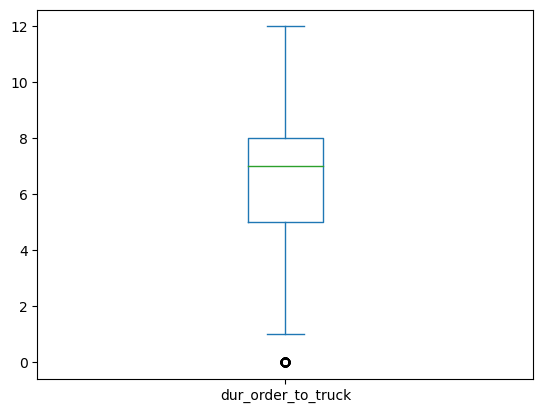

In [16]:
values_order_to_truck.plot.box()

### work on combined_ready_to_ship

* keep only relevant coloumns 
* create `weekday` columns 
* check if `order_date` is Mo-Fr
* calculate durations

In [17]:
combined_ready_to_ship.columns

Index(['index', 'order_id', 'order_date_x', 'ship_mode_x', 'customer_id',
       'customer_name', 'origin_channel', 'country/region', 'city', 'state',
       'postal_code', 'region', 'category', 'sub-category', 'product_id',
       'sales', 'quantity', 'discount', 'profit', 'row_id', 'order_date_y',
       'on_truck_scan_date', 'ship_mode_y', 'ready_to_ship_date',
       'pickup_date'],
      dtype='object')

keep relevant columns

In [18]:
### keep only relevant columns for shipping time 
ready_to_ship_keepers = (['order_id', 
                        "ship_mode_x",
                        "order_date_x",
                        "ready_to_ship_date",
                        "on_truck_scan_date"]
                        )

combined_ready_to_ship = combined_ready_to_ship[ready_to_ship_keepers]

### clean column names
combined_ready_to_ship.columns = combined_ready_to_ship.columns.str.replace("_x", "")
combined_ready_to_ship.head(2)

,order_id,ship_mode,order_date,ready_to_ship_date,on_truck_scan_date
0,CA-2020-119004,Standard Class,2020-11-23,2020-11-30,2020-12-02
1,CA-2019-145625,Standard Class,2019-09-11,2019-09-17,2019-09-18


create weekday columns

In [19]:
### create weekday columns for order_weekday & ready_to_ship_date 
### also in _int
combined_ready_to_ship["order_weekday"] = combined_ready_to_ship["order_date"].dt.day_name()
combined_ready_to_ship["order_weekday_int"] = combined_ready_to_ship["order_date"].dt.weekday

combined_ready_to_ship["ready_to_ship_weekday"] = combined_ready_to_ship["ready_to_ship_date"].dt.day_name()
combined_ready_to_ship["ready_to_ship_weekday_int"] = combined_ready_to_ship["ready_to_ship_date"].dt.weekday

combined_ready_to_ship["on_truck_weekday"] = combined_ready_to_ship["on_truck_scan_date"].dt.day_name()
combined_ready_to_ship["on_truck_weekday_int"] = combined_ready_to_ship["on_truck_scan_date"].dt.weekday

combined_ready_to_ship.head(2)

,order_id,ship_mode,order_date,ready_to_ship_date,on_truck_scan_date,order_weekday,order_weekday_int,ready_to_ship_weekday,ready_to_ship_weekday_int,on_truck_weekday,on_truck_weekday_int
0,CA-2020-119004,Standard Class,2020-11-23,2020-11-30,2020-12-02,Monday,0,Monday,0,Wednesday,2
1,CA-2019-145625,Standard Class,2019-09-11,2019-09-17,2019-09-18,Wednesday,2,Tuesday,1,Wednesday,2


check if order date is Mo-Fri // Mo-We-Fr

In [20]:
### create columns with values 1 or 0 for weekday/weekend RESP. 1 or 0 for MoWeFr or other days 

mo_fr = [0, 1, 2, 3, 4]
mo_we_fr = [0, 2, 4]

combined_ready_to_ship["order_is_weekday"] = np.where(combined_ready_to_ship["order_weekday_int"].isin(mo_fr), 1, 0)
combined_ready_to_ship["truck_scan_is_mowefr"] = np.where(combined_ready_to_ship["on_truck_weekday_int"].isin(mo_we_fr), 1, 0)
combined_ready_to_ship["ready_to_ship_is_mowefr"] = np.where(combined_ready_to_ship["ready_to_ship_weekday_int"].isin(mo_we_fr), 1, 0)       

combined_ready_to_ship.head(2)

,order_id,ship_mode,order_date,ready_to_ship_date,on_truck_scan_date,order_weekday,order_weekday_int,ready_to_ship_weekday,ready_to_ship_weekday_int,on_truck_weekday,on_truck_weekday_int,order_is_weekday,truck_scan_is_mowefr,ready_to_ship_is_mowefr
0,CA-2020-119004,Standard Class,2020-11-23,2020-11-30,2020-12-02,Monday,0,Monday,0,Wednesday,2,1,1,1
1,CA-2019-145625,Standard Class,2019-09-11,2019-09-17,2019-09-18,Wednesday,2,Tuesday,1,Wednesday,2,1,1,0


calculate duration `order_to_ready2ship` 
--> how long does it take from order received until it is ready to ship (phase 1)

In [21]:
combined_ready_to_ship["dur_order_to_ready2ship"] = (
                                                    (combined_ready_to_ship["ready_to_ship_date"] 
                                                    - combined_ready_to_ship["order_date"])
                                                    .dt.days
                                                    )

combined_ready_to_ship.head(2)

,order_id,ship_mode,order_date,ready_to_ship_date,on_truck_scan_date,order_weekday,order_weekday_int,ready_to_ship_weekday,ready_to_ship_weekday_int,on_truck_weekday,on_truck_weekday_int,order_is_weekday,truck_scan_is_mowefr,ready_to_ship_is_mowefr,dur_order_to_ready2ship
0,CA-2020-119004,Standard Class,2020-11-23,2020-11-30,2020-12-02,Monday,0,Monday,0,Wednesday,2,1,1,1,7
1,CA-2019-145625,Standard Class,2019-09-11,2019-09-17,2019-09-18,Wednesday,2,Tuesday,1,Wednesday,2,1,1,0,6


calculate duration `dur_ready2ship_to_ontruck` 
--> how long does it take from order is ready to ship until it is in truck (phase 2)

In [22]:
combined_ready_to_ship["dur_ready2ship_to_ontruck"] = (
                                                    (combined_ready_to_ship["on_truck_scan_date"] 
                                                    - combined_ready_to_ship["ready_to_ship_date"])
                                                    .dt.days
                                                    )

combined_ready_to_ship.head(2)

,order_id,ship_mode,order_date,ready_to_ship_date,on_truck_scan_date,order_weekday,order_weekday_int,ready_to_ship_weekday,ready_to_ship_weekday_int,on_truck_weekday,on_truck_weekday_int,order_is_weekday,truck_scan_is_mowefr,ready_to_ship_is_mowefr,dur_order_to_ready2ship,dur_ready2ship_to_ontruck
0,CA-2020-119004,Standard Class,2020-11-23,2020-11-30,2020-12-02,Monday,0,Monday,0,Wednesday,2,1,1,1,7,2
1,CA-2019-145625,Standard Class,2019-09-11,2019-09-17,2019-09-18,Wednesday,2,Tuesday,1,Wednesday,2,1,1,0,6,1


set variables for combined_ready_to_ship

In [23]:
### phase 1
values_order_to_ready2ship = combined_ready_to_ship["dur_order_to_ready2ship"]

<AxesSubplot: >

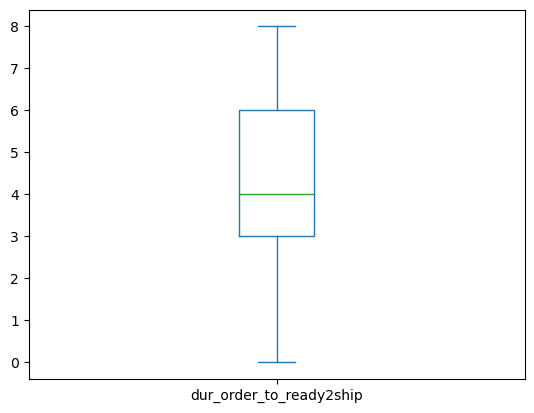

In [24]:
values_order_to_ready2ship.plot.box()

In [25]:
### phase 2
values_ready2ship_to_ontruck = combined_ready_to_ship["dur_ready2ship_to_ontruck"]

<AxesSubplot: >

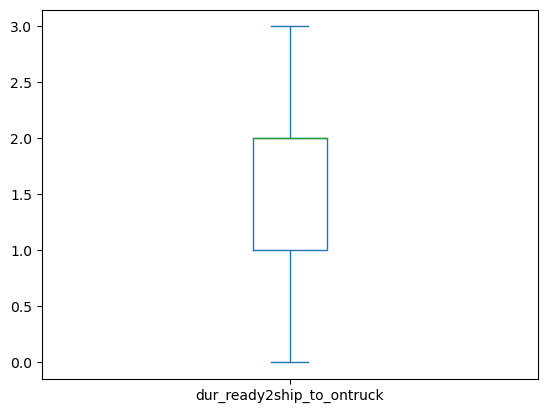

In [26]:
values_ready2ship_to_ontruck.plot.box()

### work on combined_arrival

* keep only relevant coloumns 
* create `weekday` columns 
* check if `order_date` is Mo-Fr
* calculate durations

keep only relevant columns

In [27]:
combined_arrival.columns

Index(['index', 'order_id', 'order_date_x', 'ship_mode_x', 'customer_id',
       'customer_name_x', 'origin_channel', 'country/region', 'city', 'state',
       'postal_code', 'region', 'category', 'sub-category', 'product_id',
       'sales', 'quantity', 'discount', 'profit', 'row_id', 'order_date_y',
       'on_truck_scan_date', 'ship_mode_y', 'arrival_scan_date',
       'customer_name_y'],
      dtype='object')

In [28]:
### keep only relevant columns for shipping time 
arrival_keepers = (['order_id', 
                    "ship_mode_x",
                    "order_date_x",
                    "on_truck_scan_date",
                    "arrival_scan_date"]
                    )

combined_arrival = combined_arrival[arrival_keepers]

### clean column names
combined_arrival.columns = combined_arrival.columns.str.replace("_x", "")
combined_arrival.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date,arrival_scan_date
0,CA-2019-145625,Standard Class,2019-09-11,2019-09-18,2019-09-23
1,CA-2019-162138,Standard Class,2019-04-23,2019-05-01,2019-05-06


create weekday

In [29]:
### create weekday columns for order_weekday & ready_to_ship_date 
### also in _int
combined_arrival["on_truck_weekday"] = combined_arrival["on_truck_scan_date"].dt.day_name()
combined_arrival["on_truck_weekday_int"] = combined_arrival["on_truck_scan_date"].dt.weekday

combined_arrival["order_weekday"] = combined_arrival["order_date"].dt.day_name()
combined_arrival["order_weekday_int"] = combined_arrival["order_date"].dt.weekday

combined_arrival.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date,arrival_scan_date,on_truck_weekday,on_truck_weekday_int,order_weekday,order_weekday_int
0,CA-2019-145625,Standard Class,2019-09-11,2019-09-18,2019-09-23,Wednesday,2,Wednesday,2
1,CA-2019-162138,Standard Class,2019-04-23,2019-05-01,2019-05-06,Wednesday,2,Tuesday,1


check if on_truck_weekday is mo/we/fri

In [30]:
### create columns with values 1 or 0 for MoWeFr or other days 

mo_we_fr = [0, 2, 4]

combined_arrival["truck_scan_is_mowefr"] = np.where(combined_arrival["on_truck_weekday_int"].isin(mo_we_fr), 1, 0)
combined_arrival["order_is_weekday"] = np.where(combined_arrival["order_weekday_int"].isin(mo_fr), 1, 0)

combined_arrival.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date,arrival_scan_date,on_truck_weekday,on_truck_weekday_int,order_weekday,order_weekday_int,truck_scan_is_mowefr,order_is_weekday
0,CA-2019-145625,Standard Class,2019-09-11,2019-09-18,2019-09-23,Wednesday,2,Wednesday,2,1,1
1,CA-2019-162138,Standard Class,2019-04-23,2019-05-01,2019-05-06,Wednesday,2,Tuesday,1,1,1


calculate duration `dur_truck_to_arrival` 
--> how long does it take from truck scan until it is delivered (phase 3)

In [31]:
combined_arrival["dur_truck_to_arrival"] = (
                                           (combined_arrival["arrival_scan_date"] 
                                           - combined_arrival["on_truck_scan_date"])
                                           .dt.days
                                           )

combined_arrival.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date,arrival_scan_date,on_truck_weekday,on_truck_weekday_int,order_weekday,order_weekday_int,truck_scan_is_mowefr,order_is_weekday,dur_truck_to_arrival
0,CA-2019-145625,Standard Class,2019-09-11,2019-09-18,2019-09-23,Wednesday,2,Wednesday,2,1,1,5
1,CA-2019-162138,Standard Class,2019-04-23,2019-05-01,2019-05-06,Wednesday,2,Tuesday,1,1,1,5


calculate duration `dur_total` --> total duration from order to arrival

In [32]:
combined_arrival["dur_total"] = (
                                (combined_arrival["arrival_scan_date"] 
                                - combined_arrival["order_date"])
                                .dt.days
                                )

combined_arrival.head(2)

,order_id,ship_mode,order_date,on_truck_scan_date,arrival_scan_date,on_truck_weekday,on_truck_weekday_int,order_weekday,order_weekday_int,truck_scan_is_mowefr,order_is_weekday,dur_truck_to_arrival,dur_total
0,CA-2019-145625,Standard Class,2019-09-11,2019-09-18,2019-09-23,Wednesday,2,Wednesday,2,1,1,5,12
1,CA-2019-162138,Standard Class,2019-04-23,2019-05-01,2019-05-06,Wednesday,2,Tuesday,1,1,1,5,13


set variables for combined_arrival 

In [33]:
### phase 3
values_truck_to_arrival = combined_arrival["dur_truck_to_arrival"]

In [34]:
### total phase 
values_total_duration = combined_arrival["dur_total"]

<AxesSubplot: >

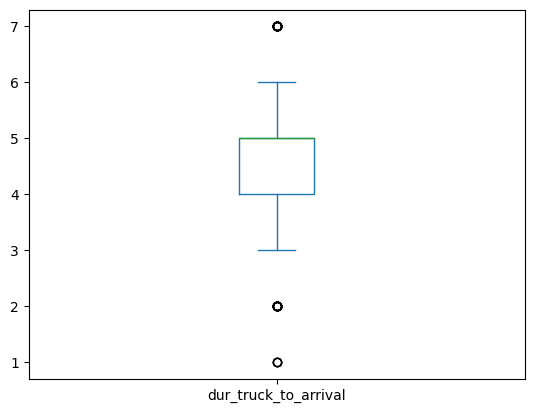

In [35]:
values_truck_to_arrival.plot.box()

# DF's & Variables
* Phase 1: order date -> ready to ship
    * combined_ready_to_ship["dur_order_to_ready2ship"]
    * values_order_to_ready2ship
* Phase 2: ready to ship -> truck scan
    * combined_ready_to_ship["dur_ready2ship_to_ontruck"]
    * values_ready2ship_to_ontruck
* Phase 3: truck scan -> arrival
    * combined_arrival["dur_truck_to_arrival"]
    * values_truck_to_arrival
* Total: order date -> arrival date 
    * combined_arrvial["dur_total"]
    * values_total_duration

# Stage 1 - Correlation with Weekdays 

In [36]:
combined_ready_to_ship[["dur_order_to_ready2ship", "order_is_weekday", "truck_scan_is_mowefr", "ready_to_ship_is_mowefr" ]].corr()

,dur_order_to_ready2ship,order_is_weekday,truck_scan_is_mowefr,ready_to_ship_is_mowefr
dur_order_to_ready2ship,1.000000,-0.048033,0.036734,0.150440
order_is_weekday,-0.048033,1.000000,0.037814,-0.059757
truck_scan_is_mowefr,0.036734,0.037814,1.000000,-0.039649
ready_to_ship_is_mowefr,0.150440,-0.059757,-0.039649,1.000000


In [37]:
### check the samplesize
combined_ready_to_ship[["order_is_weekday", "truck_scan_is_mowefr", "ready_to_ship_is_mowefr" ]].value_counts()

order_is_weekday  truck_scan_is_mowefr  ready_to_ship_is_mowefr
1                 1                     1                          122
                                        0                           50
                  0                     1                           12
0                 1                     1                           11
1                 0                     0                            4
0                 1                     0                            3
                  0                     1                            2
dtype: int64

# Stage 2 - Correlation with Weekdays

In [38]:
combined_ready_to_ship[["dur_ready2ship_to_ontruck", "order_is_weekday", "truck_scan_is_mowefr", "ready_to_ship_is_mowefr"]].corr()

,dur_ready2ship_to_ontruck,order_is_weekday,truck_scan_is_mowefr,ready_to_ship_is_mowefr
dur_ready2ship_to_ontruck,1.000000,-0.131038,-0.321759,0.330126
order_is_weekday,-0.131038,1.000000,0.037814,-0.059757
truck_scan_is_mowefr,-0.321759,0.037814,1.000000,-0.039649
ready_to_ship_is_mowefr,0.330126,-0.059757,-0.039649,1.000000


In [39]:
### check the samplesize
combined_ready_to_ship[["order_is_weekday", "truck_scan_is_mowefr", "ready_to_ship_is_mowefr"]].value_counts()

order_is_weekday  truck_scan_is_mowefr  ready_to_ship_is_mowefr
1                 1                     1                          122
                                        0                           50
                  0                     1                           12
0                 1                     1                           11
1                 0                     0                            4
0                 1                     0                            3
                  0                     1                            2
dtype: int64

# Stage 3 - Correlation with Weekdays

In [40]:
combined_arrival[["dur_truck_to_arrival", "truck_scan_is_mowefr", "order_is_weekday"]].corr()

,dur_truck_to_arrival,truck_scan_is_mowefr,order_is_weekday
dur_truck_to_arrival,1.000000,-0.072926,0.197702
truck_scan_is_mowefr,-0.072926,1.000000,0.078553
order_is_weekday,0.197702,0.078553,1.000000


In [41]:
### check the samplesize
combined_arrival[["truck_scan_is_mowefr", "order_is_weekday"]].value_counts()

truck_scan_is_mowefr  order_is_weekday
1                     1                   255
                      0                    68
0                     1                     6
                      0                     4
dtype: int64

# Stage 1+2 - Correlation

In [42]:
combined[["dur_order_to_truck", "order_is_weekday", "on_truck_is_mowefr"]].corr()

,dur_order_to_truck,order_is_weekday,on_truck_is_mowefr
dur_order_to_truck,1.000000,-0.115309,-0.020374
order_is_weekday,-0.115309,1.000000,-0.016465
on_truck_is_mowefr,-0.020374,-0.016465,1.000000


In [43]:
combined[["order_is_weekday", "on_truck_is_mowefr"]].value_counts()

order_is_weekday  on_truck_is_mowefr
1                 1                     2417
0                 1                      462
1                 0                      107
0                 0                       16
dtype: int64

# Plot Distribution of duration in all 3 shipping Stages

In [99]:
### calculatin the number of observations for each stage
s1_count = str(values_order_to_ready2ship.count())
s2_count = str(values_ready2ship_to_ontruck.count())
s3_count = str(values_truck_to_arrival.count())

### set var for mean in each stage 
s1_mean = str(round(values_order_to_ready2ship.mean(),1))
s2_mean = str(round(values_ready2ship_to_ontruck.mean(),1))
s3_mean = str(round(values_truck_to_arrival.mean(),1))

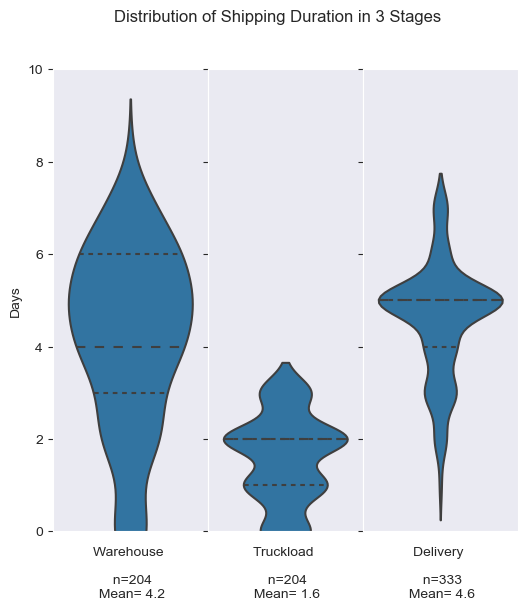

In [100]:
sns.set_style("dark")

fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0])
fig.suptitle("Distribution of Shipping Duration in 3 Stages")

sns.violinplot(data=values_order_to_ready2ship, inner="quartile")
ax.set_xlabel("Warehouse \n\n n=" + s1_count + "\n Mean= " + s1_mean)
ax.set_ylabel("Days")
ax.tick_params(left=True, bottom=False)
ax.set(xticklabels=[])
plt.ylim([0,10])


ax = fig.add_subplot(gs[0, 1])
sns.violinplot(data=values_ready2ship_to_ontruck, inner="quartile")
ax.set_xlabel("Truckload \n\n n=" + s2_count + "\n Mean= " + s2_mean)
ax.set_ylabel(None)
ax.tick_params(left=True, bottom=False)
ax.set(xticklabels=[], yticklabels=[])
plt.ylim([0,10])


ax = fig.add_subplot(gs[0, 2])
sns.violinplot(data=values_truck_to_arrival, inner="quartile")
ax.set_xlabel("Delivery \n\n n=" + s3_count + "\n Mean= " + s3_mean)
ax.tick_params(left=True, bottom=False)
ax.set(xticklabels=[], yticklabels=[])
plt.ylim([0,10])

plt.subplots_adjust(wspace=0) # changes space between the subplots

fig.tight_layout
plt.show()

# Plot Distribution of Truckload Stage (#2)

* duration of Truckload Stage has the highest correlation (0.33) with specific weekdays (Mo,We,Fr)
* show the time difference of Orders that have to wait for Truckleave on Mo/We/Fr, and those who don't

In [46]:
### print correlation once again
combined_ready_to_ship[["dur_ready2ship_to_ontruck", "ready_to_ship_is_mowefr"]].corr()

,dur_ready2ship_to_ontruck,ready_to_ship_is_mowefr
dur_ready2ship_to_ontruck,1.000000,0.330126
ready_to_ship_is_mowefr,0.330126,1.000000


In [94]:
### set values (days) for Orders that are 'ready to ship' on Mo/We/Fr 
stage2_mowefr = combined_ready_to_ship[combined_ready_to_ship["ready_to_ship_is_mowefr"] == 1]["dur_ready2ship_to_ontruck"]
### set var for mean in plot
s2_mean_mowefr = str(round(stage2_mowefr.mean(),1))
s2_mean_mowefr

'1.8'

In [92]:
### set values (days) for all other Orders
### reset index to avoid "keyerror = 0" - (warum auch immer..)
stage2_other = combined_ready_to_ship[combined_ready_to_ship["ready_to_ship_is_mowefr"] == 0]["dur_ready2ship_to_ontruck"].reset_index()["dur_ready2ship_to_ontruck"]
### set var for mean in plot
s2_mean_other = str(round(stage2_other.mean(),1))
s2_mean_other

'1.1'

In [95]:
### total values (days)
stage2_total = combined_ready_to_ship["dur_ready2ship_to_ontruck"]
### set var for mean in plot
s2_mean_total = str(round(stage2_total.mean(),1))
s2_mean_total

'1.6'

In [52]:
### calculatin the number of observations for each stage
s2_mowefr_count = str(stage2_mowefr.count())
s2_other_count = str(stage2_other.count())
s2_total_count = str(stage2_total.count())


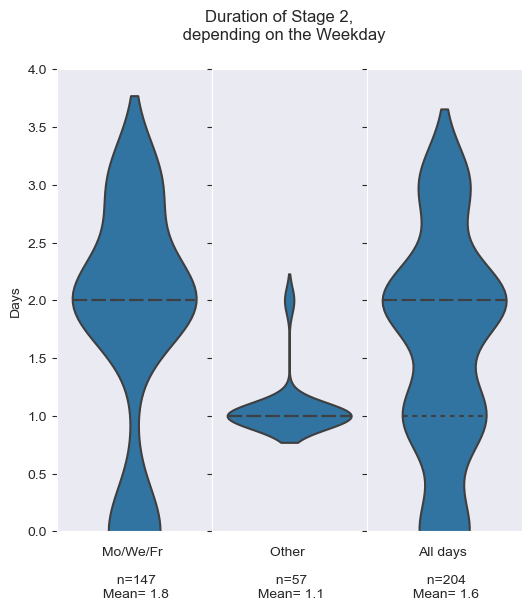

In [97]:
sns.set_style("dark")

fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0])
fig.suptitle("Duration of Stage 2, \n depending on the Weekday")

sns.violinplot(data=stage2_mowefr, inner="quartiles")
ax.set_xlabel("Mo/We/Fr \n\n n=" + s2_mowefr_count + "\n Mean= " + s2_mean_mowefr)
ax.set_ylabel("Days")
ax.tick_params(left=True, bottom=False)
ax.set(xticklabels=[])
plt.ylim([0,4])


ax = fig.add_subplot(gs[0, 1])
sns.violinplot(data=stage2_other, inner="quartile")
ax.set_xlabel("Other \n\n n=" + s2_other_count + "\n Mean= " + s2_mean_other)
ax.tick_params(left=True, bottom=False)
ax.set(xticklabels=[], yticklabels=[])
plt.ylim([0,4])


ax = fig.add_subplot(gs[0, 2])
sns.violinplot(data=stage2_total, inner="quartile")
ax.set_xlabel("All days \n\n n=" + s2_total_count + "\n Mean= " + s2_mean_total)
ax.tick_params(left=True, bottom=False)
ax.set(xticklabels=[], yticklabels=[])
plt.ylim([0,4])

plt.subplots_adjust(wspace=0) # changes space between the subplots

fig.tight_layout
plt.show()

# Calculate & Plot Average shipping time for each class in each stage

In [136]:
#Stage 1:
s1_first = round(combined_ready_to_ship[combined_ready_to_ship["ship_mode"] == "First Class"]["dur_order_to_ready2ship"].mean(), 1)
s1_second = round(combined_ready_to_ship[combined_ready_to_ship["ship_mode"] == "Second Class"]["dur_order_to_ready2ship"].mean(), 1)
s1_standard = round(combined_ready_to_ship[combined_ready_to_ship["ship_mode"] == "Standard Class"]["dur_order_to_ready2ship"].mean(), 1)
s1_total = round(combined_ready_to_ship["dur_order_to_ready2ship"].mean(), 1)
stage_1 = [1, s1_first, s1_second, s1_standard, s1_total]

In [137]:
#Stage 2:
s2_first = round(combined_ready_to_ship[combined_ready_to_ship["ship_mode"] == "First Class"]["dur_ready2ship_to_ontruck"].mean(), 1)
s2_second = round(combined_ready_to_ship[combined_ready_to_ship["ship_mode"] == "Second Class"]["dur_ready2ship_to_ontruck"].mean(), 1)
s2_standard = round(combined_ready_to_ship[combined_ready_to_ship["ship_mode"] == "Standard Class"]["dur_ready2ship_to_ontruck"].mean(), 1)
s2_total = round(combined_ready_to_ship["dur_ready2ship_to_ontruck"].mean(), 1)
stage_2 = [2, s2_first, s2_second, s2_standard, s2_total]

In [138]:
#Stage 3:
s3_first = round(combined_arrival[combined_arrival["ship_mode"] == "First Class"]["dur_truck_to_arrival"].mean(), 1)
s3_second = round(combined_arrival[combined_arrival["ship_mode"] == "Second Class"]["dur_truck_to_arrival"].mean(), 1)
s3_standard = round(combined_arrival[combined_arrival["ship_mode"] == "Standard Class"]["dur_truck_to_arrival"].mean(), 1)
s3_total = round(combined_arrival["dur_truck_to_arrival"].mean(), 1)
stage_3 = [3, s3_first, s3_second, s3_standard, s3_total]

In [139]:
stage_1

[1, 2.0, 3.9, 5.4, 4.2]

In [159]:
avg_shipping_time = pd.DataFrame([stage_1, stage_2, stage_3], columns= ["Stage", "First Class", "Second Class", "Standard Class", "Total"])

In [141]:
avg_shipping_time

,Stage,First Class,Second Class,Standard Class,Total
0,1,2.0,3.9,5.4,4.2
1,2,0.4,1.8,2.1,1.6
2,3,4.5,4.6,4.6,4.6


In [160]:
df_melt = avg_shipping_time.melt(id_vars="Stage")

#sns.barplot(x=avg_shipping_time.columns, y=avg_shipping_time.rows)

Text(0.5, 0, 'Shipping Stage')

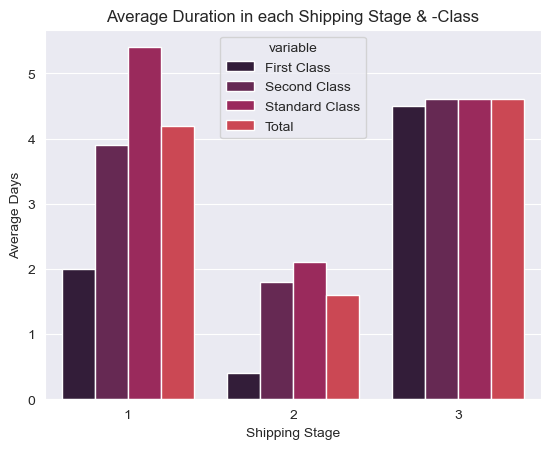

In [180]:
sns.set_style("darkgrid")
plt.title("Average Duration in each Shipping Stage & -Class")
sns.set_palette("rocket")
sns.barplot(x=df_melt["Stage"], y=df_melt["value"], hue=df_melt["variable"])
plt.ylabel("Average Days")
plt.xlabel("Shipping Stage")
